# Pre-requisites - IMPORTANT!!!

In order to run properly this notebook, you need to:

1. Have a `.env` at the root of your project (You can use `.env.example` with the values on it)
2. Run `export PYTHONPATH=$PWD` in the root of the project

In [1]:
import os
import numpy as np
from dotenv import load_dotenv, dotenv_values

from conabio.src.utils.save import save_json, save_list_as_csv
from conabio.src.utils.search import search_image_by_cumulus
from conabio.src.login.user import set_environment, MAX_ITEMS
from conabio.src.utils.read import read_json

### Load the environment set at the root (.env)

In [2]:
load_dotenv()
CONFIG = dotenv_values()

### Configure your Parameters:

- The cumulus you want to extract images from

- The output path were the results are going to be saved


In [3]:
CUMULUS = 92
OUTPUT_PATH = "../../../results/search/"

## CONSTANTS

In [4]:
BUCKET_NAME = "sipecam-open-data"
FILE_TYPE = "Audio"

Create the output path if not exists 

In [5]:
path_exists = os.path.exists(OUTPUT_PATH)
if not path_exists:
    os.makedirs(OUTPUT_PATH, exist_ok=False)

Do the search in alfresco in order to obtain the paths in the bucket

In [6]:
if CONFIG.get("ALFRESCO_API_ENDPOINT") is None or CONFIG.get("ALFRESCO_API_KEY") is None:
    raise Exception("Keys not detected")
else:
    skipcount = 0
    end_of_pagination = False
    saved_files = []
    
    # A cumulus can have more than the MAX_ITEMS allowed in the pagination, so
    # a loop is necessary.
    while not end_of_pagination:
        # The search result is going to be without any date limitation

        result = search_image_by_cumulus(CUMULUS, config=CONFIG, skipcount=skipcount)
        try:
            if not result["list"]["pagination"]["hasMoreItems"]:
                end_of_pagination = True
        except:
            if result["error"]:
                raise Exception(result["error"])

        file_name = f"{OUTPUT_PATH}/search_result_{FILE_TYPE}_{CUMULUS}_{skipcount}.json"
        # Every pagination will be saved as a json
        save_json(result, file_name)
        saved_files.append(file_name)
        skipcount += MAX_ITEMS
        
        
    path_list = []
    
    # Afterward we only want to extract the path in order to find easily the images
    for json_file in saved_files:
        result = read_json(json_file)

        totalItems = result["list"]["pagination"]["totalItems"]
        entries_list = (result["list"]["entries"])

        for entry in entries_list:
            complete_path = f'{entry["entry"]["path"]["name"]}/{entry["entry"]["name"]}'
            
            # This replacement name will depend on your mounting path.
            complete_path = complete_path.replace("/Company Home/Sites/sipecam/documentLibrary/", f"data/")
            path_list.append([complete_path])
    
    path_csv = f"{OUTPUT_PATH}/{FILE_TYPE}_path_{CUMULUS}.csv"
    save_list_as_csv(path_csv, ["item"], path_list)

## Access to one object

In [7]:
import boto3
from PIL import Image
from io import BytesIO

In [8]:
s3_client = boto3.client('s3')

In [9]:
path = path_list[0][0]

In [10]:
obj = s3_client.get_object(Bucket=BUCKET_NAME, Key=path)
image_stream = obj['Body'].read()
image = Image.open(BytesIO(image_stream))

print(f"""Width: {image.width}
Height: {image.height}""")

Width: 2048
Height: 1440


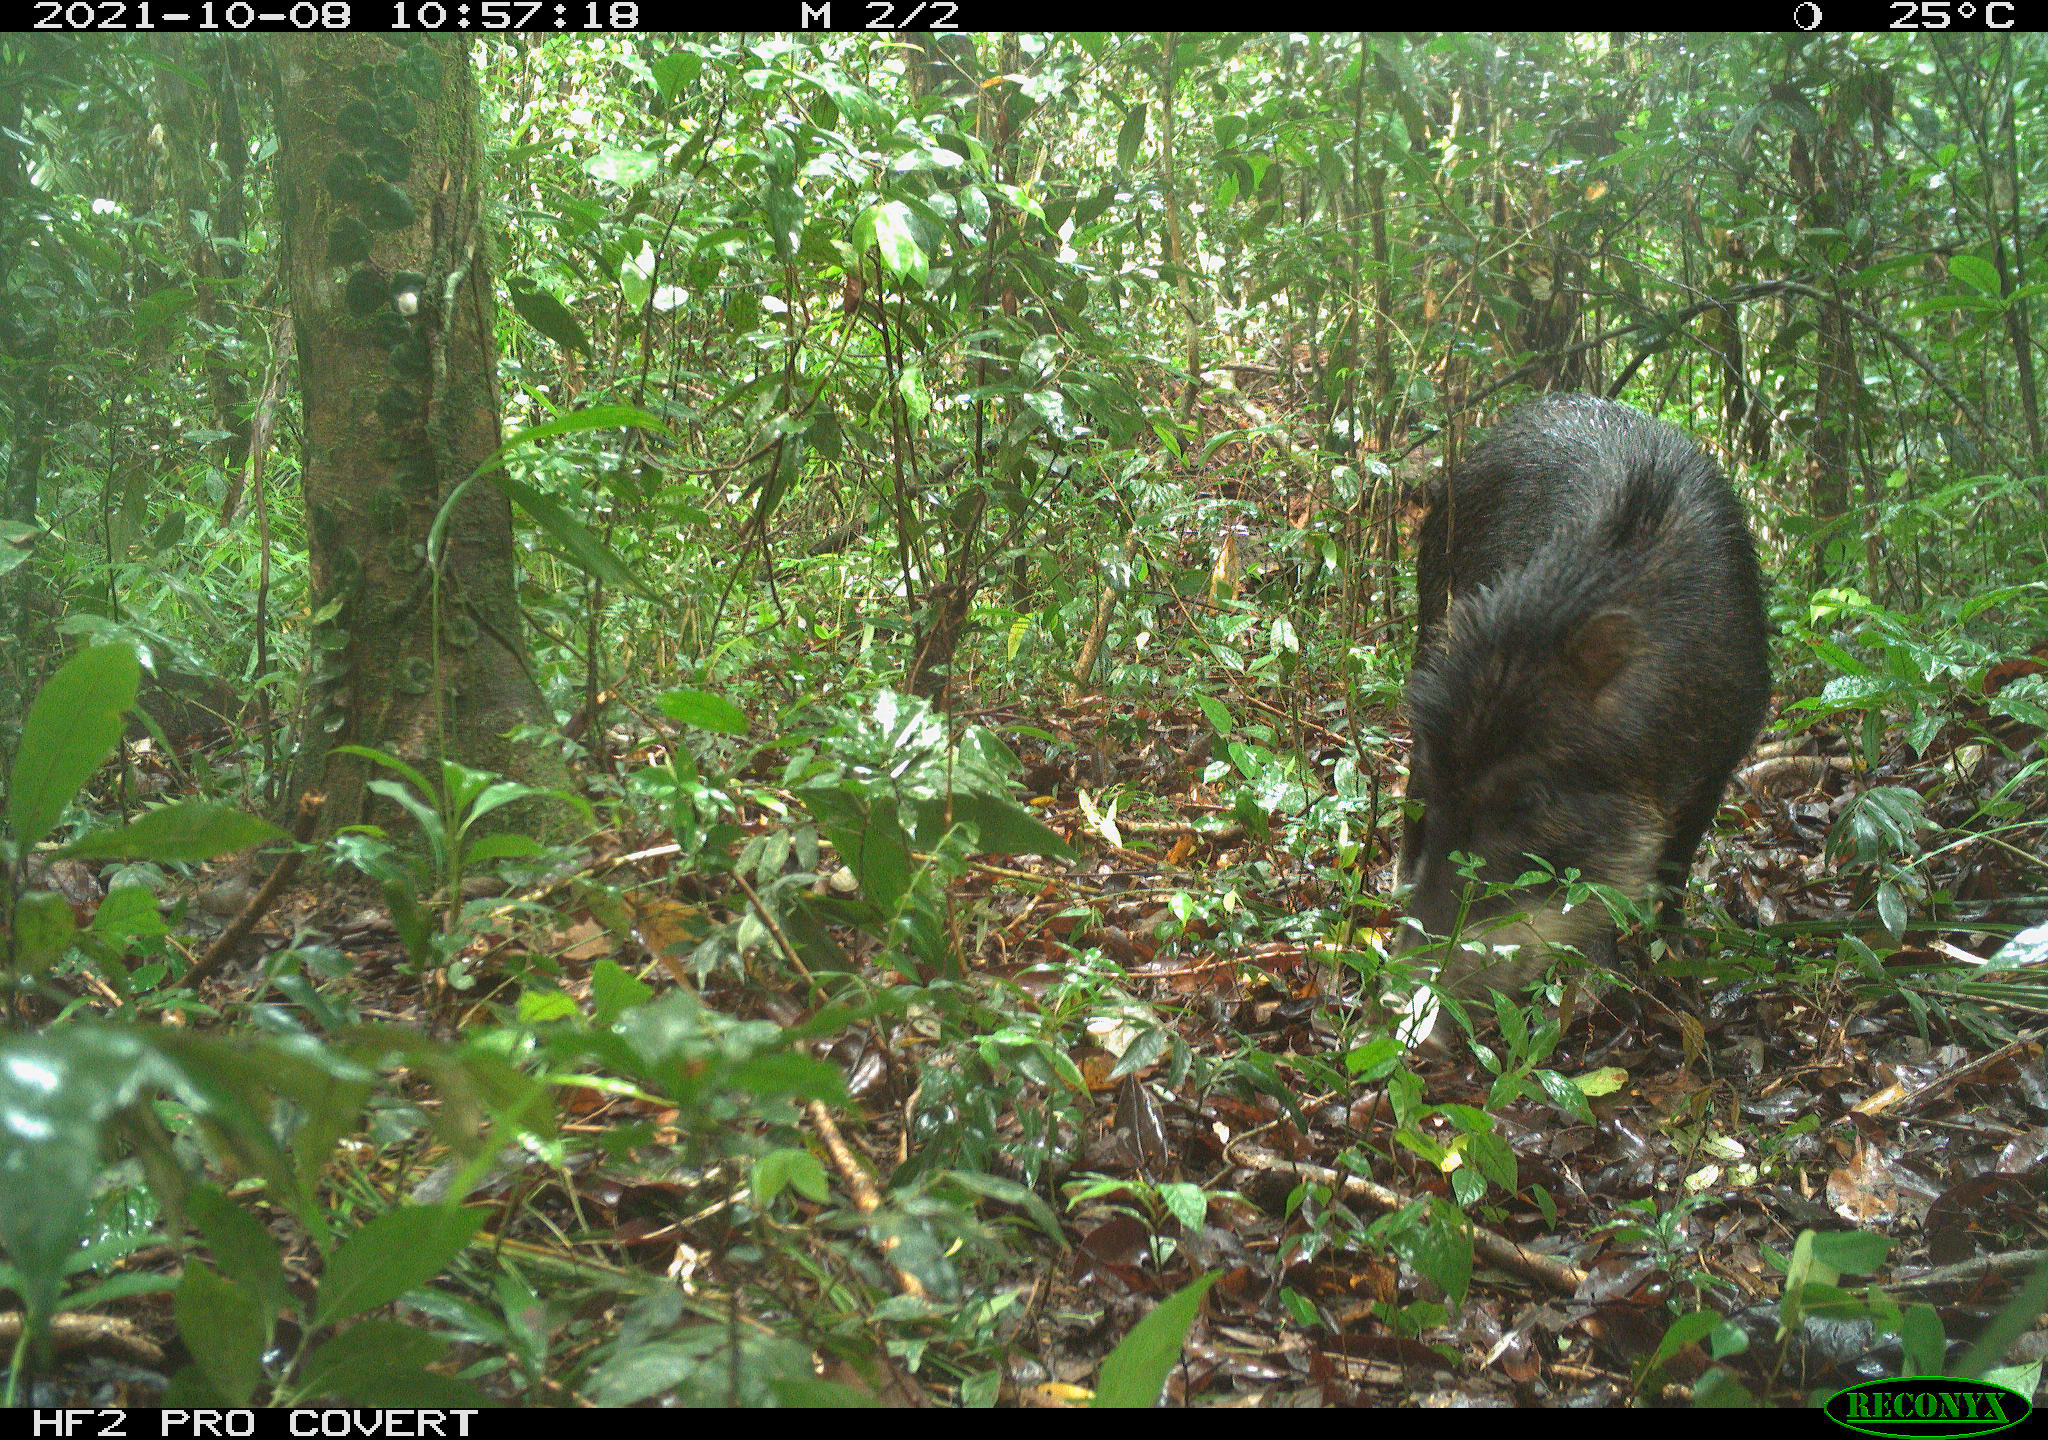

In [11]:
display(image)